<center> <a href="https://github.com/CyConProject?tab=repositories">
  <img src="https://github.com/CyConProject/Lab/blob/main/Figures/CyCon.png?raw=true" alt="logo" width="80" >
</a>
 </center>


# DBSCAN Clustering

In this lab, we will explore **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise), focusing on clustering a simple, **2D synthetic** dataset. DBSCAN is particularly suited for finding clusters in data of **arbitrary shapes** and for identifying **outliers** (noise points). 

Imagine a construction scenario where you collect **soil compaction** and **water content** measurements at different sites. You want to group these sites by similarity and detect any anomalous readings. This is precisely the type of problem DBSCAN can handle effectively.

### Objectives

By the end of this lab, you will be able to:

1. **Generate a 2D synthetic dataset** that mimics real-world soil measurements.  
2. **Preprocess and scale** data for DBSCAN.  
3. **Perform DBSCAN clustering** and extract cluster labels.  
4. **Visualize and interpret** the resulting clusters in a 2D scatter plot.  
5. **Identify outliers** in the data.

## Step 1: Import necessary libraries

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline


## Step 2: Create a Synthetic 2D Dataset

We will simulate soil measurements with **two features**:

1. **Soil_Compaction** (e.g., in g/cm³)  
2. **Water_Content** (percentage of water by weight)

We’ll generate three natural clusters plus a handful of random points acting as outliers.

In [237]:
# For reproducibility
np.random.seed(42)

# Number of samples per cluster
samples_per_cluster = 60

# Define the cluster centers (Compaction, WaterContent)
centers = [
    (1.2, 18),  # Cluster 1: moderately compact soil, medium water content
    (1.5, 25),  # Cluster 2: higher compaction, higher water content
    (0.8, 9)   # Cluster 3: lower compaction, lower water content
]

# Generate clusters
all_data = []
for cx, cy in centers:
    # Create points around each center using normal distribution
    compaction = np.random.normal(cx, 0.08, samples_per_cluster)  
    water = np.random.normal(cy, 2.0, samples_per_cluster)  
    cluster_data = np.column_stack((compaction, water))
    all_data.append(cluster_data)

# Concatenate clusters
all_data = np.vstack(all_data)

# (Optional) Add a few random outliers
num_outliers = 20
outliers_compaction = np.random.uniform(low=0.5, high=2.0, size=num_outliers)
outliers_water = np.random.uniform(low=5, high=30, size=num_outliers)
outliers = np.column_stack((outliers_compaction, outliers_water))

# Combine main data with outliers
all_data = np.vstack([all_data, outliers])

# Create DataFrame
df = pd.DataFrame(all_data, columns=["Soil_Compaction", "Water_Content"])

# Display the first few rows
df.head()


,Soil_Compaction,Water_Content
0,1.239737,17.041652
1,1.188939,17.628682
2,1.251815,15.787330
3,1.321842,15.607587
4,1.181268,19.625052


**Why these values?** We chose plausible ranges for **soil compaction** and **water content** to illustrate the clustering. Outliers might represent unusual site conditions.

## Step 3: Data Preprocessing

### 3.1 Check for Missing Values

It’s good practice to ensure no missing entries exist:

In [238]:
missing_values = df.isnull().sum()
print(missing_values)


Soil_Compaction    0
Water_Content      0
dtype: int64


### 3.2 Feature Scaling

DBSCAN is distance-based. Features with larger numerical ranges could dominate the distance metric, so we **scale** both features:


In [239]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["Soil_Compaction", "Water_Content"]])

# Convert to DataFrame for convenience
df_scaled = pd.DataFrame(scaled_data, columns=["Soil_Compaction", "Water_Content"])
df_scaled.head()


,Soil_Compaction,Water_Content
0,0.158640,-0.070251
1,0.005156,0.015400
2,0.195133,-0.253263
3,0.406717,-0.279488
4,-0.018022,0.306681


## Step 4: DBSCAN Model Construction and Training

**DBSCAN** has two key parameters:  
1. **eps (ε)**: The radius within which points are considered neighbors.  
2. **min_samples**: The minimum number of data points required to form a dense region.  

DBSCAN starts with an unvisited point, checks its neighbors within `eps`, and if there are at least `min_samples` neighbors, it forms a cluster. Points that do not belong to any cluster are **outliers** (labeled -1).


In [240]:
# Set DBSCAN parameters
eps_value = 0.3
min_samples_val = 5

dbscan_model = DBSCAN(eps=eps_value, min_samples=min_samples_val)
dbscan_model.fit(df_scaled)

# Retrieve cluster labels
labels = dbscan_model.labels_
print("Unique labels:", np.unique(labels))


Unique labels: [-1  0  1  2]


**Interpretation**:  
- `labels` gives the cluster assignments for each point.  
- A label of `-1` indicates an **outlier** point that doesn’t belong to any cluster.

## Step 5: Analyzing and Visualizing Clusters

### 5.1 Determine Number of Clusters

In [241]:
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters (excluding outliers): {num_clusters}")


Number of clusters (excluding outliers): 3


### 5.2 Plot Clusters in 2D

Let’s plot **Soil_Compaction** vs. **Water_Content**, coloring each cluster differently. Outliers (label = -1) will be shown in black.


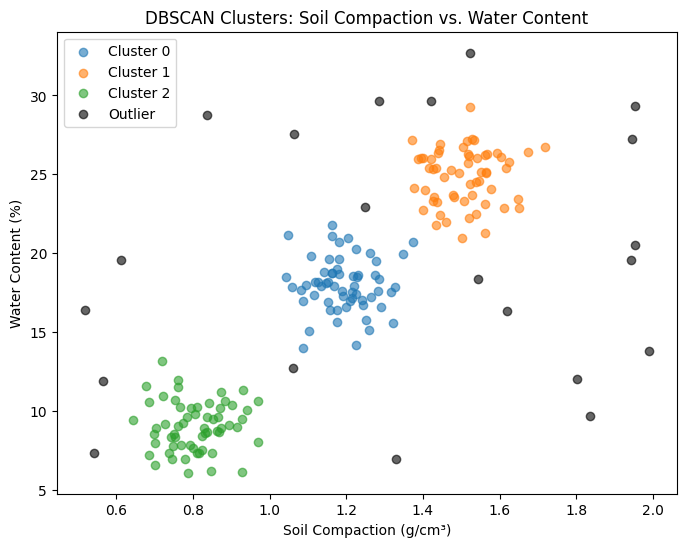

In [242]:
# Attach cluster labels to the original DataFrame
df["Cluster"] = labels

# Prepare color palette
import matplotlib.colors as mcolors
unique_labels = set(labels)
colors_list = list(mcolors.TABLEAU_COLORS.values())

plt.figure(figsize=(8, 6))
for label in unique_labels:
    # Black color for outliers
    color = 'k' if label == -1 else colors_list[label % len(colors_list)]
    cluster_data = df[df["Cluster"] == label]
    plt.scatter(
        cluster_data["Soil_Compaction"], 
        cluster_data["Water_Content"],
        c=color,
        alpha=0.6,
        label=('Outlier' if label == -1 else f'Cluster {label}')
    )

plt.xlabel("Soil Compaction (g/cm³)")
plt.ylabel("Water Content (%)")
plt.title("DBSCAN Clusters: Soil Compaction vs. Water Content")
plt.legend()
plt.show()


## Step 6: Outlier Detection

We can see which points DBSCAN labeled as **outliers**:

In construction, these might warrant further investigation (e.g., sampling error or truly exceptional site conditions).



In [243]:
outliers = df[df["Cluster"] == -1]
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 21


,Soil_Compaction,Water_Content,Cluster
14,1.062007,12.760510,-1
53,1.248934,22.926484,-1
89,1.523759,32.705463,-1
100,1.422025,29.629317,-1
142,0.540699,7.363559,-1


If you have many outliers, you may need to adjust `eps` or `min_samples` so you don’t lose too many potentially valid points.

## Step 7: Evaluating Cluster Quality

Unlike supervised classification, clustering does not have simple accuracy metrics. However, we can use the **Silhouette Score** to measure how well each data point fits into its assigned cluster. A higher silhouette score (close to 1) indicates better clustering.


In [244]:
from sklearn.metrics import silhouette_score

# We only compute silhouette if there's more than 1 cluster found
if num_clusters > 1:
    score = silhouette_score(df_scaled, labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Cannot compute Silhouette Score with fewer than 2 clusters.")

Silhouette Score: 0.585


## Practice

Here are some exercises to enhance your understanding:

1. **Parameter Tuning**: Change the values of `eps` (e.g., 0.3, 0.6, 0.8) and `min_samples` (e.g., 3, 8) to see how they affect the number of clusters and outliers. 

   How does the number of clusters differ from the original run?


In [245]:
### Your Code Here



<details><summary>Click here for a sample solution</summary>

```python
# Varying eps and min_samples
from sklearn.metrics import silhouette_score

eps_values = [0.3, 0.6, 0.8]
min_samples_list = [3, 8]

for eps_v in eps_values:
    for min_s in min_samples_list:
        dbscan_temp = DBSCAN(eps=eps_v, min_samples=min_s)
        dbscan_temp.fit(df_scaled)
        temp_labels = dbscan_temp.labels_
        n_clusters_temp = len(set(temp_labels)) - (1 if -1 in temp_labels else 0)
        n_outliers_temp = list(temp_labels).count(-1)
        
        # Compute silhouette if more than 1 cluster
        if n_clusters_temp > 1:
            silhouette_temp = silhouette_score(df_scaled, temp_labels)
            print(f"eps={eps_v}, min_samples={min_s} => Clusters: {n_clusters_temp}, "
                  f"Outliers: {n_outliers_temp}, Silhouette: {silhouette_temp:.3f}")
        else:
            print(f"eps={eps_v}, min_samples={min_s} => Clusters: {n_clusters_temp}, "
                  f"Outliers: {n_outliers_temp}, Silhouette: N/A")
```


1. **When `eps` is small** (0.3):
   - The algorithm is *strict* about how far points can be from each other to be in the same cluster.  
   - This typically allows multiple clusters to form (3 in this example).  
   - Increasing `min_samples` from 3 to 8 makes DBSCAN require *denser* areas to form a cluster, so more points end up labeled as outliers (20 → 23), but it still detects 3 core clusters.

2. **When `eps` is moderate** (0.6):
   - Many points end up connected in a single region, especially when data points aren’t super spread out.  
   - Everything merges into *1 cluster* plus some outliers.  
   - You cannot compute a silhouette score for a **single cluster** (hence `N/A`).

3. **When `eps` is large** (0.8):
   - Points are considered neighbors even if fairly far apart, making it more likely to merge into fewer clusters.  
   - You sometimes see 2 clusters, but if you raise `min_samples` to 8, you end up with 1 big cluster (outliers are reduced or included in that single cluster).  
   - A silhouette score near 0.239 for 2 clusters indicates poor separation or a forced clustering structure.

**Takeaway**: This demonstrates DBSCAN’s sensitivity to `eps` and `min_samples`. In a real situation, you’d choose these parameters based on domain knowledge, or tune them to maximize a metric like silhouette (while also making practical sense for your data).


</details>

2. **Compare with K-Means**: Perform K-Means with `n_clusters=3` (since we roughly know there are 3 main clusters). Compare cluster assignments to DBSCAN.



In [246]:
### Your Code Here


<details><summary>Click here for a sample solution</summary>

```python

from sklearn.cluster import KMeans

# We suspect 3 main clusters
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(df_scaled)
kmeans_labels = kmeans_model.labels_

df["KMeans_Cluster"] = kmeans_labels

# Quick comparison
print("DBSCAN clusters:", np.unique(df["Cluster"]))
print("K-Means clusters:", np.unique(kmeans_labels))

# Display how many points ended up in each cluster with each method
print("\nDBSCAN cluster counts:")
print(df["Cluster"].value_counts())

print("\nK-Means cluster counts:")
print(df["KMeans_Cluster"].value_counts())

# (Optional) Evaluate Silhouette Score
from sklearn.metrics import silhouette_score
km_sil_score = silhouette_score(df_scaled, kmeans_labels)
db_sil_score = silhouette_score(df_scaled, labels)
print(f"\nK-Means Silhouette Score: {km_sil_score:.3f}")
print(f"DBSCAN Silhouette Score: {db_sil_score:.3f}")
```

</details>

3. Try a different **scaling** technique, such as **MinMaxScaler**, and see if it changes the DBSCAN results. Then check whether the number of outliers or clusters changes significantly. 

In [247]:
### Your Code Here


<details>
<summary>Click here for a sample solution</summary>

```python
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler
mms = MinMaxScaler()
scaled_data_mms = mms.fit_transform(df[["Soil_Compaction", "Water_Content"]])

# Perform DBSCAN with the same eps and min_samples
dbscan_mms = DBSCAN(eps=0.3, min_samples=5)
dbscan_mms.fit(scaled_data_mms)
labels_mms = dbscan_mms.labels_

# Analyze results
n_clusters_mms = len(set(labels_mms)) - (1 if -1 in labels_mms else 0)
n_outliers_mms = list(labels_mms).count(-1)

print(f"Number of clusters with MinMaxScaler: {n_clusters_mms}")
print(f"Number of outliers with MinMaxScaler: {n_outliers_mms}")

# Optional silhouette
if n_clusters_mms > 1:
    sil_mms = silhouette_score(scaled_data_mms, labels_mms)
    print(f"Silhouette Score with MinMaxScaler: {sil_mms:.3f}")
else:
    print("Not enough clusters to compute silhouette score.")
```

**Discussion**: Different scaling methods can produce different distance relationships among data points, which may change how DBSCAN forms clusters or identifies outliers. 

- **Why only one cluster?**  
  MinMax scaling compresses all features into a [0,1] range. If the data points are not extremely spread out, this can bring them *closer together* in feature space—especially under a particular `eps`—so DBSCAN sees them as one large dense region.
- **No outliers?**  
  Because points are so “close,” DBSCAN can treat them all as neighbors in a single cluster.  
- **No silhouette score?**  
  Again, there’s only one cluster. The silhouette score needs at least two clusters to make sense.

  Try it again with `eps`= 0.1.

</details>


## Additional Tips 

- **Practical Parameter Selection**: In real scenarios, use domain knowledge (e.g., typical soil property ranges) to guide `eps`. For instance, if two points differ in compaction by more than `x g/cm³`, you may not consider them neighbors.  
- **Consider Other Distances**: For geospatial data, you might use Haversine distance. For advanced feature sets, consider using a dimensionality reduction (like PCA) **before** DBSCAN.  
- **Double-Check Outliers**: Some “outliers” may actually be interesting or valuable anomalies worthy of further investigation rather than just noise.

In this lab, you explored **DBSCAN** on a simple, two-feature dataset. DBSCAN:

- **Automatically** determines the number of clusters based on data density.  
- Labels points that don’t belong to any dense region as **outliers**.  
- Handles **arbitrary cluster shapes** better than many partitional methods like K-Means.

This approach is highly relevant in construction tasks such as **soil site investigations**, where you may encounter localized variations and outliers due to geological anomalies. By adjusting DBSCAN’s parameters, you can refine cluster boundaries and identify points deserving deeper analysis.

**Happy clustering!**